# iQuHack 2026 - Quantum Entanglement Distillation Game

In this game, you design quantum circuits to distill noisy Bell pairs and claim edges in a network.

**Game Flow**: Register -> Select Starting Node -> Design Circuits -> Claim Edges -> Score Points

In [38]:
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import json
from pathlib import Path
import numpy as np

## Session Management

Save/load your session to avoid re-registering.

In [112]:
SESSION_FILE = Path("session.json")

def save_session(client):
    if client.api_token:
        with open(SESSION_FILE, "w") as f:
            json.dump({"api_token": client.api_token, "player_id": client.player_id, "name": client.name}, f)
        print(f"Session saved.")

def load_session():
    if not SESSION_FILE.exists():
        return None
    with open(SESSION_FILE) as f:
        data = json.load(f)
    client = GameClient(api_token=data.get("api_token"))
    client.player_id = data.get("player_id")
    client.name = data.get("name")
    status = client.get_status()
    if status:
        print(f"Resumed: {client.player_id} | Score: {status.get('score', 0)} | Budget: {status.get('budget', 0)}")
        return client
    return None

In [113]:
# Try to resume existing session
client = load_session()

if not client:
    print("No saved session. Register below.")

No saved session. Register below.


## Step 1: Register

Skip this if you resumed a session above.

In [114]:
if client and client.api_token:
    print(f"Already registered as {client.player_id}")
else:
    client = GameClient()
    
    # CHANGE THESE to your unique values
    PLAYER_ID = "qt_Teddy"
    PLAYER_NAME = "Pranavishvar"
    
    result = client.register(PLAYER_ID, PLAYER_NAME, location=input("remote or in_person: ").strip())
    
    if result.get("ok"):
        print(f"Registered! Token: {client.api_token[:20]}...")
        candidates = result["data"].get("starting_candidates", [])
        print(f"\nStarting candidates ({len(candidates)}):")
        for c in candidates:
            print(f"  - {c['node_id']}: {c['utility_qubits']} qubits, +{c['bonus_bell_pairs']} bonus")
        save_session(client)
    else:
        print(f"Failed: {result.get('error', {}).get('message')}")

Registered! Token: F_p5aSNVulWzXfwlmrR1...

Starting candidates (4):
  - Sofia, Bulgaria: 3 qubits, +0 bonus
  - Ahmedabad, India: 4 qubits, +0 bonus
  - Kharkiv, Ukraine: 3 qubits, +0 bonus
  - Zagreb, Croatia: 3 qubits, +0 bonus
Session saved.


## Step 2: Select Starting Node

In [115]:
status = client.get_status()

if status.get('starting_node'):
    print(f"Starting node: {status['starting_node']}")
    print(f"Budget: {status['budget']} | Score: {status['score']}")
else:
    print("Select a starting node from the candidates shown above.")
    # Uncomment and modify:
    result = client.select_starting_node("Ahmedabad, India")
    print(result)

Select a starting node from the candidates shown above.
{'ok': True, 'data': {'success': True, 'starting_node': 'Ahmedabad, India', 'score': 0, 'budget': 40}}


## Step 3: Explore the Network

In [116]:
client.print_status()

Player: qt_Teddy (Pranavishvar)
Score: 0 | Budget: 40 bell pairs
Active: Yes
Starting node: Ahmedabad, India
Owned: 1 nodes, 0 edges
Claimable edges: 4
  - ['Ahmedabad, India', 'Mumbai, India']: threshold=0.90, difficulty=3
  - ['Ahmedabad, India', 'Pune, India']: threshold=0.90, difficulty=3
  - ['Ahmedabad, India', 'Karachi, Pakistan']: threshold=0.90, difficulty=3
  ... and 1 more


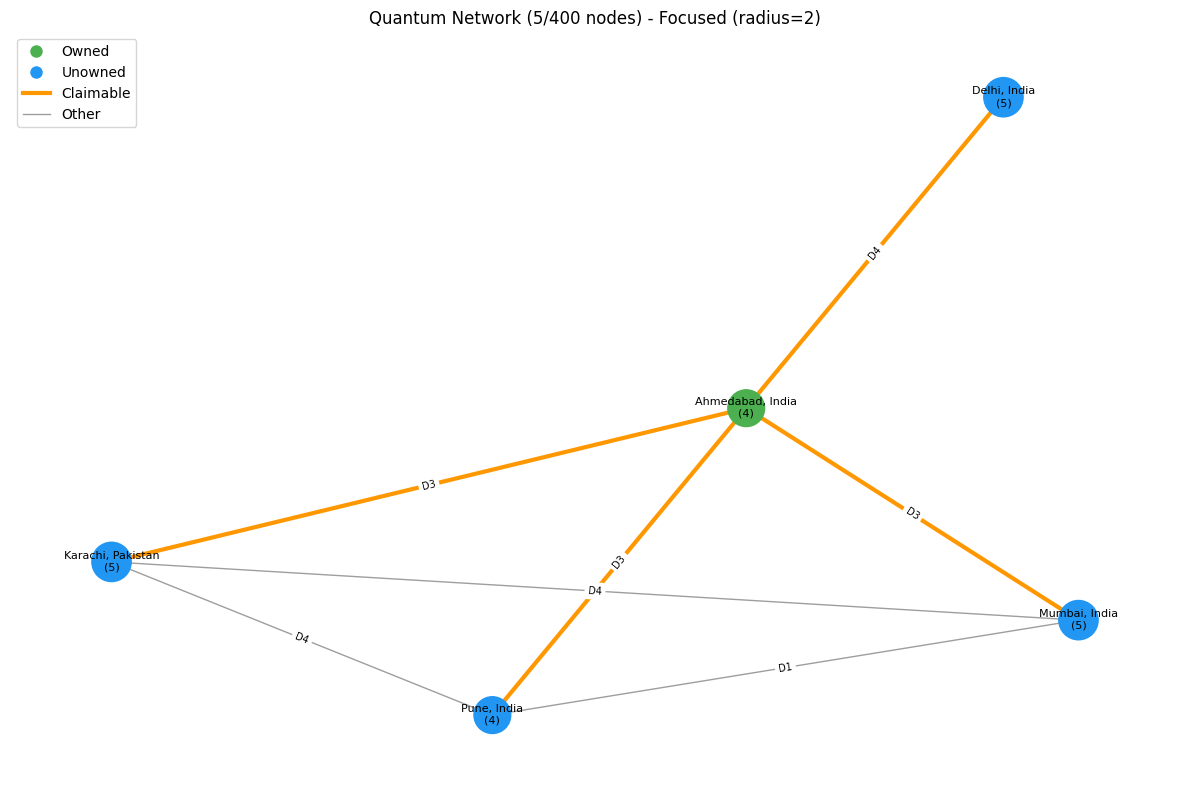

In [117]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

## Step 4: Design a Distillation Circuit

For N Bell pairs, qubits are paired outside-in:
- Pair 0: qubits {0, 2N-1}
- Pair 1: qubits {1, 2N-2}
- ...
- Final pair: qubits {N-1, N}

Design a circuit that improves fidelity through LOCC operations.

In [135]:
def create_distillation_circuit(num_rounds=2):
    """Example distillation circuit template for 2 Bell pairs."""
    if num_rounds < 1:
        raise ValueError("num_rounds must be >= 1")

    num_pairs = num_rounds + 1
    num_qubits = 2 * num_pairs

    qr = QuantumRegister(num_qubits, "q")

    # Classical registers
    mA_x = ClassicalRegister(num_rounds, "mA_x")
    par_x = ClassicalRegister(num_rounds, "par_x")
    mA_z = ClassicalRegister(num_rounds, "mA_z")
    par_z = ClassicalRegister(num_rounds, "par_z")
    flag  = ClassicalRegister(1, "flag")

    qc = QuantumCircuit(qr, mA_x, par_x, mA_z, par_z, flag)

    # Survivor indices (middle pair)
    sA = num_rounds
    sB = num_rounds + 1

    # Ancilla pairs
    ancilla_pairs = [
        (k, num_qubits - 1 - k) for k in range(num_rounds)
    ]

    # ==================================================
    # X-ERROR (BIT FLIP) CHECKS
    # ==================================================
    for k, (aA, aB) in enumerate(ancilla_pairs):
        qc.cx(qr[sA], qr[aA])
        qc.cx(qr[sB], qr[aB])

        qc.measure(qr[aA], mA_x[k])

        with qc.if_test((mA_x[k], 1)):
            qc.x(qr[aB])

        qc.measure(qr[aB], par_x[k])

    # ==================================================
    # Z-ERROR (PHASE FLIP) CHECKS
    # ==================================================
    for q in range(num_qubits):
        qc.h(qr[q])

    for k, (aA, aB) in enumerate(ancilla_pairs):
        qc.cx(qr[sA], qr[aA])
        qc.cx(qr[sB], qr[aB])

        qc.measure(qr[aA], mA_z[k])

        with qc.if_test((mA_z[k], 1)):
            qc.x(qr[aB])

        qc.measure(qr[aB], par_z[k])

    # ==================================================
    # INTERNAL FLAG = OR(all par_x, par_z)
    # ==================================================
    qc.reset(qr[0])  # scratch qubit

    for k in range(num_rounds):
        with qc.if_test((par_x[k], 1)):
            qc.x(qr[0])
        with qc.if_test((par_z[k], 1)):
            qc.x(qr[0])

    qc.measure(qr[0], flag[0])

    return qc

circuit = create_distillation_circuit()
print(circuit.draw(output='text'))

         ┌───┐┌─┐┌───┐                                                        »
    q_0: ┤ X ├┤M├┤ H ├────────────────────────────────────────────────────────»
         └─┬─┘└╥┘├───┤                             ┌─┐┌───┐                   »
    q_1: ──┼───╫─┤ X ├─────────────────────────────┤M├┤ H ├───────────────────»
           │   ║ └─┬─┘                             └╥┘├───┤                   »
    q_2: ──■───╫───■────────────────────────────────╫─┤ H ├───────────────────»
               ║                                    ║ ├───┤                   »
    q_3: ──■───╫───■────────────────────────────────╫─┤ H ├───────────────────»
           │   ║ ┌─┴─┐                              ║ └───┘   ┌──────    ┌───┐»
    q_4: ──┼───╫─┤ X ├──────────────────────────────╫─────────┤ If-0  ───┤ X ├»
         ┌─┴─┐ ║ └───┘   ┌──────    ┌───┐ ───────┐  ║  ┌─┐    └──╥───    └───┘»
    q_5: ┤ X ├─╫─────────┤ If-0  ───┤ X ├  End-0 ├──╫──┤M├───────╫────────────»
         └───┘ ║         └──╥───    └───

## Step 5: Claim an Edge

In [136]:
# Find claimable edges
claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

print(f"Claimable edges ({len(claimable)}):")
for edge in claimable_sorted[:5]:
    if edge['difficulty_rating'] == 3:
        print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")

Claimable edges (4):
  ['Ahmedabad, India', 'Mumbai, India'] - threshold: 0.900, difficulty: 3
  ['Ahmedabad, India', 'Pune, India'] - threshold: 0.900, difficulty: 3
  ['Ahmedabad, India', 'Karachi, Pakistan'] - threshold: 0.900, difficulty: 3


In [137]:
edges_with_count = []
for edge in claimable_sorted:
    count = 0
    for e in claimable_sorted:
        if e["edge_id"][1] == edge["edge_id"][1]:
            count+=1
    edges_with_count.append((edge, count))

print(sorted(edges_with_count, key = lambda e: (e[1], e[0]['difficulty_rating'], e[0]['base_threshold']), reverse=True))

[({'edge_id': ['Ahmedabad, India', 'Delhi, India'], 'base_threshold': 0.92, 'difficulty_rating': 4, 'successful_attempts': 6}, 1), ({'edge_id': ['Ahmedabad, India', 'Mumbai, India'], 'base_threshold': 0.9, 'difficulty_rating': 3, 'successful_attempts': 5}, 1), ({'edge_id': ['Ahmedabad, India', 'Pune, India'], 'base_threshold': 0.9, 'difficulty_rating': 3, 'successful_attempts': 1}, 1), ({'edge_id': ['Ahmedabad, India', 'Karachi, Pakistan'], 'base_threshold': 0.9, 'difficulty_rating': 3, 'successful_attempts': 5}, 1)]


In [138]:
# Claim an edge
claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))
owned = set(client.get_status().get('owned_nodes', []))

edges_with_count = []
for edge in claimable_sorted:
    count = 0
    for e in claimable_sorted:
        if e["edge_id"][1] == edge["edge_id"][1]:
            count+=1
    edges_with_count.append((edge, count))

claimable_sorted_with_max_count = sorted(edges_with_count, key = lambda e: (e[1], e[0]['difficulty_rating'], e[0]['base_threshold']), reverse=True)

for edge in claimable_sorted:

    if claimable:
        target = edge # Easiest edge
        edge_id = tuple(target['edge_id'])
        
        num_bell_pairs = 2
        circuit = create_distillation_circuit(num_bell_pairs - 1)
        flag_bit = circuit.num_clbits - 1  # Classical bit for post-selection (keep when flag=0)
        
        print(f"Claiming {edge_id} (threshold: {target['base_threshold']:.3f})...")
        
        result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)
        
        if result.get("ok"):
            data = result["data"]
            print(f"Success: {data.get('success')}")
            print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
            print(f"Success probability: {data.get('success_probability', 0):.4f}")
            if data.get('success'):
                break
        else:
            print(f"Error: {result.get('error', {}).get('message')}")

Claiming ('Ahmedabad, India', 'Mumbai, India') (threshold: 0.900)...
Success: False
Fidelity: 0.7500 (threshold: 0.9000)
Success probability: 0.5000
Claiming ('Ahmedabad, India', 'Pune, India') (threshold: 0.900)...
Success: False
Fidelity: 0.7500 (threshold: 0.9000)
Success probability: 0.5000
Claiming ('Ahmedabad, India', 'Karachi, Pakistan') (threshold: 0.900)...
Success: False
Fidelity: 0.7500 (threshold: 0.9000)
Success probability: 0.5000
Claiming ('Ahmedabad, India', 'Delhi, India') (threshold: 0.920)...
Success: False
Fidelity: 0.5968 (threshold: 0.9200)
Success probability: 0.5000


## Step 6: Check Progress

In [139]:
client.print_status()

Player: qt_Teddy (Pranavishvar)
Score: 0 | Budget: 40 bell pairs
Active: Yes
Starting node: Ahmedabad, India
Owned: 1 nodes, 0 edges
Claimable edges: 4
  - ['Ahmedabad, India', 'Mumbai, India']: threshold=0.90, difficulty=3
  - ['Ahmedabad, India', 'Pune, India']: threshold=0.90, difficulty=3
  - ['Ahmedabad, India', 'Karachi, Pakistan']: threshold=0.90, difficulty=3
  ... and 1 more


## Tips

- **Failed attempts are free** - only successful claims cost bell pairs
- **More bell pairs** can improve fidelity but cost more budget
- **Vertex rewards** are competitive - top players by claim strength earn rewards
- **Budget management** is key - if budget reaches 0, you're eliminated

Good luck!

In [94]:
# Restart game (uncomment to use)
result = client.restart()
print(result)

{'ok': True, 'data': {'success': True, 'budget': 75, 'is_active': True, 'starting_candidates': [{'node_id': 'Hefei, China', 'utility_qubits': 4, 'bonus_bell_pairs': 1, 'capacity': 100, 'latitude': 31.8206, 'longitude': 117.2272}, {'node_id': 'Malmo, Sweden', 'utility_qubits': 2, 'bonus_bell_pairs': 1, 'capacity': 100, 'latitude': 55.6049, 'longitude': 13.0038}, {'node_id': 'Christchurch, New Zealand', 'utility_qubits': 2, 'bonus_bell_pairs': 1, 'capacity': 100, 'latitude': -43.5321, 'longitude': 172.6362}, {'node_id': 'Cebu City, Philippines', 'utility_qubits': 3, 'bonus_bell_pairs': 1, 'capacity': 100, 'latitude': 10.3157, 'longitude': 123.8854}]}}
